In [1]:
from tqdm import tqdm 
from xml.etree import ElementTree as ET
from datetime import datetime
import re
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
raw_data = pd.read_csv('data/raw_data.csv', index_col=0)
raw_data

,status,why_stop,label,phase,diseases,icdcodes,drugs,smiless,criteria
nctid,,,,,,,,,
NCT00000102,completed,NaN,-1,phase 1/phase 2,['congenital adrenal hyperplasia'],"[""['N25.0', 'Q61.4', 'N23', 'N26.9', 'P96.0', ...",['nifedipine'],['COC(=O)C1=C(C)NC(C)=C(C1C1=CC=CC=C1[N+]([O-]...,\n Inclusion Criteria:\r\n\r\n ...
NCT00000110,completed,NaN,-1,NaN,['obesity'],"[""['E66.8', 'E66.9', 'E66.1', 'O99.214', 'O99....",['dietary fat'],[],\n Inclusion Criteria:\r\n\r\n ...
NCT00000114,completed,NaN,-1,phase 3,['retinitis pigmentosa'],[],"['vitamin e', 'vitamin a']",['CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC[C@]1(C)CCC2...,\n Men and nonpregnant women between ag...
NCT00000115,completed,NaN,-1,phase 2,"['macular edema, cystoid']",[],['acetazolamide'],['CC(=O)NC1=NN=C(S1)S(N)(=O)=O'],\n Males and females 8 years of age or ...
NCT00000117,completed,NaN,-1,phase 3,['optic neuritis'],"[""['H46.8', 'H46.9']""]",['immunoglobulin'],[],"\n To be eligible, patients must have a..."
...,...,...,...,...,...,...,...,...,...
NCT06263959,recruiting,NaN,-1,phase 2,['chronic hepatitis b'],"[""['B18.0', 'B18.1', 'B18.2', 'B18.8', 'B18.9']""]","['gst-hg131', 'placebo to match gst-hg131']",[],\n Inclusion Criteria:\r\n\r\n ...
NCT06263998,not yet recruiting,NaN,-1,phase 1,['xerophthalmia'],[],"['ncp112', 'ncp112 placebo']",[],\n Inclusion Criteria:\r\n\r\n ...
NCT06264141,recruiting,NaN,-1,phase 2,['recurrent acute rhinosinusitis'],[],['nitric oxide releasing solution'],[],\n Inclusion Criteria:\r\n\r\n ...


## Trial Duration Prediction

In [3]:
def parse_date(date_str):
    try:
        output = datetime.strptime(date_str, "%B %d, %Y")
    except:
        try:
            output = datetime.strptime(date_str, "%B %Y")
        except Exception as e:
            print(e)
            raise e
    return output

def calculate_duration(start_date, completion_date):
    # Unit: days
    if start_date and completion_date:
        start_date = parse_date(start_date)
        completion_date = parse_date(completion_date)
        duration = (completion_date - start_date).days
    else:
        duration = -1

    return duration

def xmlfile2date(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    try:
        start_date = root.find('start_date').text
    except:
        start_date = ''
    try:
        completion_date = root.find('primary_completion_date').text
    except:
        try:
            completion_date = root.find('completion_date').text 
        except:
            completion_date = ''

    return start_date, completion_date


In [4]:
date_list = []

# 480403 lines
with open("../../data/all_xml", "r") as file:
    for xml_path in tqdm(file):
        xml_path = f"../../{xml_path.strip()}"
        
        # NCT00000150 <- raw_data/NCT0000xxxx/NCT00000150.xml
        nct_id = re.search(r"/([^/]+)\.xml$", xml_path).group(1)
        
        start_date, completion_date = xmlfile2date(xml_path)

        if start_date and completion_date:
            duration = calculate_duration(start_date, completion_date)
        else:
            duration = -1

        date_list.append((nct_id, start_date, completion_date, duration))


38630it [06:35, 96.33it/s] 

In [ ]:
# 483239  lines
date_df = pd.DataFrame(date_list, columns=['ntcid', 'start_date', 'completion_date', 'time_day'])
date_df = date_df.set_index('ntcid')
print(date_df)

# date_df.to_csv('data/ntcid_time_all.csv', index=False, sep='\t')

              ntcid         start_date    completion_date  time_day
0       NCT00000102                                              -1
1       NCT00000104                                              -1
2       NCT00000105          July 2002         March 2012      3531
3       NCT00000106                                              -1
4       NCT00000107                                              -1
...             ...                ...                ...       ...
483234  NCT06264297  February 20, 2023       January 2027      1411
483235  NCT06264310         March 2024       January 2025       306
483236  NCT06264323  September 1, 2017       May 30, 2018       271
483237  NCT06264336      March 1, 2024  December 31, 2024       305
483238  NCT06264349     March 15, 2024       May 15, 2025       426

[483239 rows x 4 columns]


In [ ]:
# Filter out unusable time data.
# 469937 lines
date_df = date_df[date_df['time_day'] > 0]
date_df
# date_df.to_csv('trial-duration-prediction/ntcid_duration_time.csv', index=False, sep='\t')

,ntcid,start_date,completion_date,time_day
2,NCT00000105,July 2002,March 2012,3531
9,NCT00000113,September 1997,October 2001,1491
10,NCT00000114,May 1984,June 1987,1126
11,NCT00000115,December 1990,June 1994,1278
12,NCT00000116,May 1996,September 2002,2314
...,...,...,...,...
483234,NCT06264297,"February 20, 2023",January 2027,1411
483235,NCT06264310,March 2024,January 2025,306
483236,NCT06264323,"September 1, 2017","May 30, 2018",271
483237,NCT06264336,"March 1, 2024","December 31, 2024",305


In [ ]:
# Analysis
medium_time_day = date_df['time_day'].median()
average_time_day = date_df['time_day'].mean()
minimum_time_day = date_df['time_day'].min()
maximum_time_day = date_df['time_day'].max()
std_time_day = date_df['time_day'].std()

print("Medium time_day:", medium_time_day)
print("Average time_day:", average_time_day)
print("Minimum time_day:", minimum_time_day)
print("Maximum time_day:", maximum_time_day)
print("Standard Deviation of time_day:", std_time_day)


Medium time_day: 670.0
Average time_day: 938.2584644324664
Minimum time_day: 1
Maximum time_day: 42217
Standard Deviation of time_day: 1089.2603714569104


In [ ]:
date_df['month'] = date_df['time_day'] // 30
frequency_month = date_df['month'].value_counts().sort_index().reset_index()
print(frequency_month)

     month  count
0        0   4725
1        1  10975
2        2  11763
3        3  12175
4        4  11430
..     ...    ...
563   1252      2
564   1266      1
565   1270      1
566   1339      1
567   1407      1

[568 rows x 2 columns]


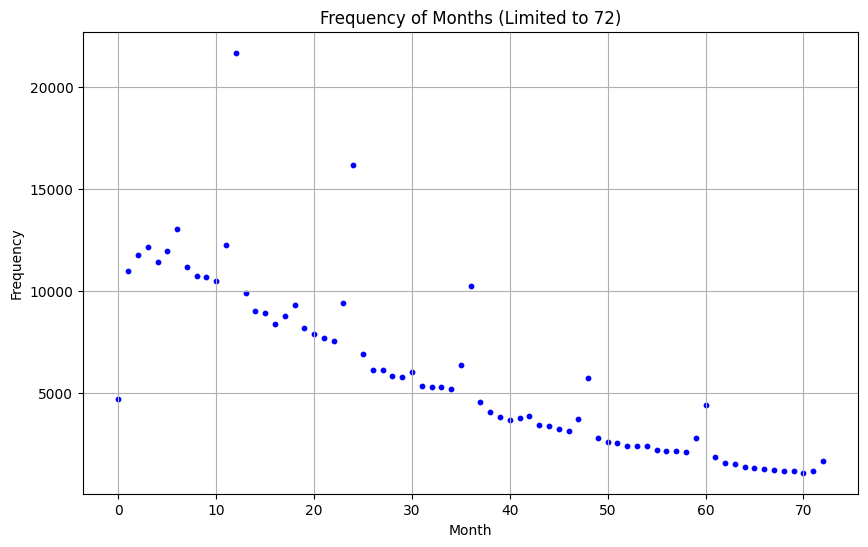

In [ ]:
plot_data = frequency_month[frequency_month['month'] <= 72]

plt.figure(figsize=(10, 6))

plt.scatter(plot_data['month'], plot_data['count'], s=10, c='blue')

plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Frequency of Months (Limited to 72)')
plt.grid(True)  # Add grid

plt.show()

In [ ]:
duration_prediction_input = raw_data[['icdcodes', 'drugs', 'criteria']]
duration_prediction_input

,icdcodes,drugs,criteria
nctid,,,
NCT00000102,"[""['N25.0', 'Q61.4', 'N23', 'N26.9', 'P96.0', ...",['nifedipine'],\n Inclusion Criteria:\r\n\r\n ...
NCT00000110,"[""['E66.8', 'E66.9', 'E66.1', 'O99.214', 'O99....",['dietary fat'],\n Inclusion Criteria:\r\n\r\n ...
NCT00000114,[],"['vitamin e', 'vitamin a']",\n Men and nonpregnant women between ag...
NCT00000115,[],['acetazolamide'],\n Males and females 8 years of age or ...
NCT00000117,"[""['H46.8', 'H46.9']""]",['immunoglobulin'],"\n To be eligible, patients must have a..."
...,...,...,...
NCT06263959,"[""['B18.0', 'B18.1', 'B18.2', 'B18.8', 'B18.9']""]","['gst-hg131', 'placebo to match gst-hg131']",\n Inclusion Criteria:\r\n\r\n ...
NCT06263998,[],"['ncp112', 'ncp112 placebo']",\n Inclusion Criteria:\r\n\r\n ...
NCT06264141,[],['nitric oxide releasing solution'],\n Inclusion Criteria:\r\n\r\n ...


In [ ]:
duration_prediction_input.isna().sum()

icdcodes     0
drugs        0
criteria    28
dtype: int64

In [ ]:
# 取交集
cross_index = list(set(duration_prediction_input.index.to_list()).intersection(set(date_df.index.to_list())))
len(cross_index)

166587

In [ ]:
cross_index

['NCT01169090',
 'NCT00836667',
 'NCT06223685',
 'NCT01660893',
 'NCT01025245',
 'NCT00620490',
 'NCT00253591',
 'NCT02095405',
 'NCT04393051',
 'NCT06038461',
 'NCT06007482',
 'NCT00755521',
 'NCT01243567',
 'NCT06248606',
 'NCT00185289',
 'NCT03209830',
 'NCT00851370',
 'NCT04493853',
 'NCT00808795',
 'NCT00285181',
 'NCT00969709',
 'NCT02558972',
 'NCT03175978',
 'NCT00004228',
 'NCT06254781',
 'NCT03753113',
 'NCT04575558',
 'NCT04413734',
 'NCT04697485',
 'NCT03502499',
 'NCT01856712',
 'NCT03784014',
 'NCT00138541',
 'NCT02357368',
 'NCT03801629',
 'NCT01035385',
 'NCT05935761',
 'NCT00414349',
 'NCT04462471',
 'NCT04646330',
 'NCT00179283',
 'NCT00414024',
 'NCT03470675',
 'NCT01805557',
 'NCT00498342',
 'NCT00531284',
 'NCT01409187',
 'NCT00001862',
 'NCT05810350',
 'NCT05948085',
 'NCT00278421',
 'NCT04099407',
 'NCT05176717',
 'NCT00261183',
 'NCT02434081',
 'NCT00533611',
 'NCT03988101',
 'NCT06049680',
 'NCT00893048',
 'NCT02642900',
 'NCT05959252',
 'NCT05678283',
 'NCT055

In [ ]:
duration_prediction_output = date_df.loc[cross_index]
duration_prediction_output

,start_date,completion_date,time_day,month
ntcid,,,,
NCT01169090,July 2010,July 2011,365,12
NCT00836667,March 2002,April 2002,31,1
NCT06223685,"April 1, 2023",August 2024,488,16
NCT01660893,August 2012,September 2012,31,1
NCT01025245,November 2009,January 2010,61,2
...,...,...,...,...
NCT04973033,"December 1, 2019","January 31, 2021",427,14
NCT03909594,"January 1, 2022","December 31, 2023",729,24
NCT02614963,December 2015,July 2016,213,7


In [ ]:
duration_prediction_input = duration_prediction_input.loc[cross_index]
duration_prediction_input

,icdcodes,drugs,criteria
nctid,,,
NCT01169090,"[""['E11.65', 'E11.9', 'E11.21', 'E11.36', 'E11...","['sk-0403', 'placebo', 'sitagliptin']",\n Inclusion Criteria:\r\n\r\n ...
NCT00836667,"[""['Z76.3', 'Z76.2']""]","['zoloft® 100 mg tablets', 'sertraline hydroch...",\n Inclusion Criteria:\r\n\r\n ...
NCT06223685,[],['rifaximin 200 mg'],\n Inclusion Criteria:\r\n\r\n ...
NCT01660893,"[""['R20.0', 'T88.51XS', 'J95.4', 'T88.2XXS', '...",['tetracaine hcl 3% and oxymetazoline hcl 0.05...,\n Inclusion Criteria:\r\n\r\n ...
NCT01025245,[],"['remifentanil, mgso4']",\n Inclusion Criteria:\r\n\r\n ...
...,...,...,...
NCT04973033,[],['tofacitinib'],\n Inclusion Criteria:\r\n\r\n ...
NCT03909594,[],"['bupivacaine', 'ketamine']",\n Inclusion Criteria:\r\n\r\n ...
NCT02614963,[],"['clostridium butyricum', 'placebo']",\n Inclusion Criteria:\r\n\r\n ...


In [ ]:
duration_prediction_input.to_csv(f'trial-duration-prediction/input.csv')
duration_prediction_output.to_csv(f'trial-duration-prediction/output.csv')

## Trial Approval Prediction

trail approval 是否是status？

In [ ]:
approval_input = raw_data[['icdcodes', 'drugs', 'criteria']]
approval_output = raw_data[['status']]

In [ ]:
def str2binary(value):
    if value == 'completed':
        return 1
    else:
        return 0
    
approval_output['label'] = approval_output['status'].apply(str2binary)

/tmp/ipykernel_2720/714254395.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approval_output['label'] = approval_output['status'].apply(str2binary)


In [ ]:
approval_input.to_csv('trial-approval-prediction/input.csv')
approval_output.to_csv('trial-approval-prediction/output.csv')

## Trial Failure Reason Prediction

选择 why_stopped? 还是只筛出trial_outcom_v1.csv的

In [ ]:
failure_input = raw_data[['icdcodes', 'drugs', 'criteria']][raw_data['status']!='completed']
failure_output = raw_data['why_stop'][raw_data['status']!='completed']

In [ ]:
raw_data['why_stop'].value_counts()

why_stop
\n    slow accrual\r\n                                                                                                                                         294
\n    sponsor decision\r\n                                                                                                                                     236
\n    low accrual\r\n                                                                                                                                          202
\n    lack of funding\r\n                                                                                                                                      178
\n    lack of enrollment\r\n                                                                                                                                   114
                                                                                                                                                              ... 
\n    b330100

In [ ]:
trial_outcome_v1 = pd.read_csv('data/IQVIA/trial_outcomes_v1.csv', index_col=0)
trial_outcome_v1

,trialOutcome
studyid,
NCT00000102,"Completed, Outcome unknown"
NCT00000105,"Terminated, Other"
NCT00000172,"Completed, Positive outcome/primary endpoint(s..."
NCT00000173,"Completed, Positive outcome/primary endpoint(s..."
NCT00000174,"Completed, Negative outcome/primary endpoint(s..."
...,...
NCT03733301,"Completed, Positive outcome/primary endpoint(s..."
NCT03733574,"Completed, Outcome unknown"
NCT03735446,"Terminated, Business decision - Other"


In [ ]:
trial_outcome_v1['trialOutcome'].value_counts()

trialOutcome
Completed, Positive outcome/primary endpoint(s) met          16067
Completed, Outcome unknown                                    9162
Completed, Outcome indeterminate                              4478
Terminated, Poor enrollment                                   4088
Completed, Negative outcome/primary endpoint(s) not met       3767
Terminated, Unknown                                           3103
Terminated, Planned but never initiated                       2562
Terminated, Other                                             2000
Terminated, Lack of efficacy                                  1682
Terminated, Business decision - Other                         1448
Terminated, Safety/adverse effects                             921
Terminated, Lack of funding                                    752
Terminated, Business decision - Pipeline reprioritization      691
Terminated, Business decision - Drug strategy shift            315
Completed, Early positive outcome                

In [ ]:
# 选择trial outcome v1 里的 Completed, Positive outcome/primary endpoint(s) met / Completed, Outcome unknown / Completed, Outcome indeterminate / 
#                         Completed, Early positive outcome 除去 
# Completed, Negative outcome/primary endpoint(s) not met 保留
## completed 里的 p-n
def Choose_completed(value):
    delete = ['Completed, Positive outcome/primary endpoint(s) met', 'Completed, Outcome unknown', ' Completed, Outcome indeterminate', 'Completed, Early positive outcome']
    if value in delete:
        return False
    else:
        return True
failure_output = trial_outcome_v1[trial_outcome_v1['trialOutcome'].apply(Choose_completed)]
failure_output['trialOutcome'].value_counts()

trialOutcome
Completed, Outcome indeterminate                             4478
Terminated, Poor enrollment                                  4088
Completed, Negative outcome/primary endpoint(s) not met      3767
Terminated, Unknown                                          3103
Terminated, Planned but never initiated                      2562
Terminated, Other                                            2000
Terminated, Lack of efficacy                                 1682
Terminated, Business decision - Other                        1448
Terminated, Safety/adverse effects                            921
Terminated, Lack of funding                                   752
Terminated, Business decision - Pipeline reprioritization     691
Terminated, Business decision - Drug strategy shift           315
Name: count, dtype: int64

In [ ]:
failure_output['label'] = failure_output['trialOutcome'].astype('category').cat.codes
failure_output['label'].value_counts()

/tmp/ipykernel_2720/3494840454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_output['label'] = failure_output['trialOutcome'].astype('category').cat.codes


label
1     4478
9     4088
0     3767
11    3103
8     2562
7     2000
5     1682
3     1448
10     921
6      752
4      691
2      315
Name: count, dtype: int64

In [ ]:
# 取交集
cross_index = list(set(failure_output.index.to_list()).intersection((failure_input.index.to_list())))
len(cross_index)

10820

In [ ]:
failure_input = failure_input.loc[cross_index]
failure_input.to_csv('trial-failure-reason-prediction/input.csv')
failure_output = failure_output.loc[cross_index]
failure_output.to_csv('trial-failure-reason-prediction/output.csv')

## Patient-Trial Matching

没有找到patient单独的信息，只有一些分组后group的信息

## Eligibility Criteria Design

trial summary/objective 选择 哪个  是否要选择completed的部分

In [ ]:
def xmlfile2text(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    try:
        brief_title = root.find('brief_title').text
    except:
        brief_title = ''
    try:
        brief_summary = root.find('brief_summary/textblock').text
    except:
        brief_summary = ''
    try:
        detailed_description = root.find('detailed_description/textblock').text 
    except:
        detailed_description = ''
    try:
        criteria = root.find('eligibility/criteria/textblock').text
    except:
        criteria = ''
    try:
        status = root.find('overall_status').text
    except:
        status = None
    try:
        phase = root.find('phase').text
    except:
        phase = None
    
    # print(brief_title, brief_summary, detailed_description, criteria, status, phase)

    return brief_title, brief_summary, detailed_description, criteria, phase, status

In [ ]:
text_list = []

with open("../../data/all_xml", "r") as file:
    for xml_path in tqdm(file):
        xml_path = f"../../{xml_path.strip()}"
        
        # NCT00000150 <- raw_data/NCT0000xxxx/NCT00000150.xml
        nct_id = re.search(r"/([^/]+)\.xml$", xml_path).group(1)
        
        brief_title, brief_summary, detailed_description, criteria, phase, status = xmlfile2text(xml_path)

        text_list.append((nct_id, brief_title, brief_summary, detailed_description, criteria, phase, status))

text_df = pd.DataFrame(text_list, columns=['ntcid', 'brief_title', 'brief_summary', 'detailed_description', 'criteria', 'phase', 'status'])
text_df = text_df.set_index('ntcid')
print(date_df)

## Drug Dose Prediction

dose information 